In [29]:
#Apostolos Kasselouris, A.M: 2994

#pandas version 1.0.5
#json version 2.0.9
#numpy version 1.19.2
#scipy version 1.5.2
#sklearn version 0.23.1
#matplotlib version 3.3.2
#seaborn version 0.11.0

import pandas as pd
import json
import numpy as np
import scipy as sp
import scipy.sparse as sp_sparse
import random

In [30]:
#STEP 1
#Prune data
def parse_businesses(): 
    with open("yelp_academic_dataset_business.json", "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            yield data

business_list = [] #list of all business_id's of Toronto City with equal or more than 15 reviews
for business in parse_businesses():
    if business['city'] == "Toronto" and business["review_count"] >= 15:
        business_list.append(business['business_id'])
        
business_set = set(business_list) #set of all business_id's of Toronto City with equal or more than 15 reviews

In [31]:
def parse_reviews(): 
    with open("yelp_academic_dataset_review.json", "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            yield data

review_list = [] #list of all review_id's of users that rated Toronto City businesses with equal or more than 15 reviews
for review in parse_reviews():
    if review['business_id'] in business_set:
        review_instance = [review['user_id'], review['business_id'], int(review['stars'])]
        review_list.append(review_instance)

unpruned_reviews_df  = pd.DataFrame(review_list, columns = ['user_id', 'business_id', 'rating']) #review_list to dataframe

In [32]:
pruned_data = unpruned_reviews_df.drop_duplicates(subset = ['user_id', 'business_id'], keep='last')  #prune duplicate reviews

df_shape_list = [pruned_data.shape[0]]
while True:
    pruned_data = pruned_data.groupby('business_id').filter(lambda x: len(x) >= 15) #prune businesses with less than 15 reviews
    pruned_data = pruned_data.groupby('user_id').filter(lambda x: len(x) >= 15)     #prune users with less than 15 reviews
    
    df_shape_list.append(pruned_data.shape[0])
    #repeat the pruning of users and businesses until the dataframe converges to a certain length
    if df_shape_list[-1] == df_shape_list[-2]:
        break

#Final result       
#user-business matrix with ratings for Toronto businesses with (user reviews >= 15) and (business reviewed >= 15)
pruned_data = pruned_data.reset_index(drop=True) #reindex
pruned_data

,user_id,business_id,rating
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4
1,AdMCAKmNDIaubYPxnjTq1g,nIIuxIn5RU0j-XkDWh3hlA,1
2,1kNsEAhGU8d8xugMuXJGFA,cDoo0Pf1d_P79Rq3ZNk-Mw,3
3,Kl6jNDAE7PG_VVQafIptxQ,IfUkm42SB9D0m_ZbkQ711A,4
4,JnPIjvC0cmooNDfsa9BmXg,nY2oBwH3s5sKox1mERIoVQ,5
...,...,...,...
197107,6Rkg-RdO9-EhDP9bbBiKZA,zHNk2BnANwkvHvaXD7yYsg,5
197108,v-HcprOKPC1_F5_15t4JDw,G2Z-4U6cDsDQvT6v3FzYmA,3
197109,aLvxbF2DueKFOqul9eVWCw,L_tieGcFMQVSmk7XiA093A,4
197110,E1hLHq6LZ6AoSJzW-oT4FQ,xF2zrVbXtB6TxMBPGJKxog,2


In [33]:
#STEP 2
#change pandas file to numpy array
#Map the string id's of users and businesses with unique serial numbers
#Warning: This jupyter window may take several minutes to run

users_list = pruned_data.user_id.unique()
businesses_list = pruned_data.business_id.unique()

pr_array = np.array(pruned_data)

for i in pr_array:
    for numU, u in enumerate(users_list):
        if u == i[0]:
            i[0] = numU
            
    for numB, b in enumerate(businesses_list):
        if b == i[1]:
            i[1] = numB
            

In [34]:
#create a user-business array with values ratings as a sparse matrix
pr_array = pr_array.astype(int)

row = pr_array[:,0]
col = pr_array[:,1]
data = pr_array[:,2]
R = sp_sparse.csr_matrix((data, (row,col)), shape=(len(users_list),len(businesses_list)))  #sparse array R in  compressed row format

# e.g:
#
# R_dense =        business0 business1 ... business4043
#           user0      5         0                0
#           user1      0         3                3          
#           ...        ...      ...      ...     ...
#           user4735   0         0       ...      0
#           
#                       &
#                       
# R =    (0, 0)      5
#        (1, 1)      3
#        (1, 4043)   3
#            ...              
#

In [35]:
#Random sampling 5% of elements from R
R_nonzero = R.nonzero()

num_sampled = np.random.choice(len(R_nonzero[0]), int(len(R_nonzero[0])*0.05), replace=False)

#here we store the sampled (user, business) review
samples_list = [[], [], []]  #[[index_X1, index_X2, ...], [index_Y1, index_Y2, ...], [value1, value2, ...]]

for i in num_sampled:
    x = R_nonzero[0][i]
    y = R_nonzero[1][i]
    
    samples_list[0].append(x)
    samples_list[1].append(y)
    samples_list[2].append(R[x, y])
    R[x, y] = 0
    
samples_array = np.array(samples_list)
R.eliminate_zeros()

In [36]:
#STEP 3 
#User-Based Collaborative Filtering (UCF)
from sklearn.metrics.pairwise import cosine_similarity
import math

cos_sim_array = cosine_similarity(R)  #cosine_similarity matrix


# cos_sim_array =  [ [cos(row 0, row 0),    cos(row 0, row 1),    ...,  cos(row 0, row 4735)],
#                    [cos(row 1, row 0),    cos(row 1, row 1),    ...,  cos(row 1, row 4735)],
#                                             ...
#                    [cos(row 4735, row 0), cos(row 4735, row 1), ...,  cos(row 4735, row 4735)] ]
#
#each row contain the similarity of a user with all other users

In [37]:
R_non0 = R.nonzero()
R_non0 = np.array(R_non0).transpose()
R_dense = R.toarray()  #from sparse to dense array

def ucf(k, u, b):
    #i)user list with users that rated business b
    users_list_b = R_non0[R_non0[:, 1] == b]
    users_list_b = users_list_b[:, 0]

    #ii)
    users_similarity_list = cos_sim_array[u, users_list_b]  #users similarity with user u
    
    #select K most similar users
    usl_len = len(users_similarity_list)
    if k <= usl_len:
        ind = np.argpartition(users_similarity_list, -k)[-k:]              #indices of K most similar users on users_list_b
    else:
        ind = np.argpartition(users_similarity_list, -usl_len)[-usl_len:]  #indices of K most similar users on users_list_b

    topK_users = users_list_b[ind] #most similar users to user u
    
    #iii)
    topK_users_similarities = users_similarity_list[ind]
    topK_users_ratings = R_dense[topK_users, b]
    
    #iv)function for recommended rating
    p = np.sum(np.multiply(topK_users_similarities, topK_users_ratings)) / np.sum(topK_users_similarities) 
    
    return p

In [38]:
#calculates the RMSE (Root Mean Square Error) of User-Based Collaborative Filtering (UCF)
def ucf_rmse(k):
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, business in enumerate(samples_array[1]):
        predicted_rating = ucf(k, samples_array[0, num], business)
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [39]:
#STEP 4
#Item-Based Collaborative Filtering (ICF)

R_transposed = R.transpose()
cos_sim_array_transposed = cosine_similarity(R_transposed)  #cosine_similarity matrix


# cos_sim_array =  [ [cos(row 0, row 0),    cos(row 0, row 1),    ...,  cos(row 0, row 4043)],
#                    [cos(row 1, row 0),    cos(row 1, row 1),    ...,  cos(row 1, row 4043)],
#                                             ...
#                    [cos(row 4043, row 0), cos(row 4043, row 1), ...,  cos(row 4043, row 4043)] ]
#
#each row contain the similarity of a business with all other businesses

In [40]:
R_non0_transposed = R_transposed.nonzero()
R_non0_transposed = np.array(R_non0_transposed).transpose()
R_dense_transposed = R_transposed.toarray()  #from sparse to dense array

def icf(k, u, b):
    #i)businesses list with businesses that rated by user u 
    businesses_list_u = R_non0_transposed[R_non0_transposed[:, 1] == u]
    businesses_list_u = businesses_list_u[:, 0]

    #ii)
    businesses_similarity_list = cos_sim_array_transposed[b, businesses_list_u]  #businesses similarity with business b
    
    #select K most similar businesses
    bsl_len = len(businesses_similarity_list)
    if k <= bsl_len:
        ind = np.argpartition(businesses_similarity_list, -k)[-k:]              #indices of K most similar businesses on businesses_list_u
    else:
        ind = np.argpartition(businesses_similarity_list, -bsl_len)[-bsl_len:]  #indices of K most similar businesses on businesses_list_u

    topK_businesses = businesses_list_u[ind] #most similar businesses to business b
    
    #iii)
    topK_businesses_similarities = businesses_similarity_list[ind]
    topK_businesses_ratings = R_dense_transposed[topK_businesses, u]
    
    #iv)function for recommended rating
    p = np.sum(np.multiply(topK_businesses_similarities, topK_businesses_ratings)) / np.sum(topK_businesses_similarities) 

    return p

In [41]:
#calculates the RMSE (Root Mean Square Error) of Item-Based Collaborative Filtering (ICF)  
def icf_rmse(k):
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, user in enumerate(samples_array[0]):
        predicted_rating = icf(k, user, samples_array[1, num])
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [42]:
#STEP 5
#Singular Value Decomposition (SVD)
from sklearn.decomposition import TruncatedSVD

#calculates the RMSE (Root Mean Square Error) of #Singular Value Decomposition (SVD) 
def svd_rmse(k):
    #calculate the Rk matrix
    svd = TruncatedSVD(n_components = k) 
    svd.fit(R)                            
    U = svd.transform(R)
    s = svd.singular_values_
    V = svd.components_
    S = np.diag(s)                        #reshape s as diagonal as it is supposed to be
    Rk = U.dot(S).dot(V)                  #calculate recommended ratings for user-business
    
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, user in enumerate(samples_array[0]):
        predicted_rating = Rk[user, samples_array[1, num]]
        #set upper and lower limit boundaries
        if predicted_rating < 0:
            predicted_rating = 0
        if predicted_rating > 5:
            predicted_rating = 5
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [43]:
#BONUS STEP
#User-Based Collaborative Filtering (UCF) that predicts deviations from the mean value

users_mean = [] #calculates the mean value of all users (rows)

for user in R_dense:
    mean = np.sum(R[user]) / sp_sparse.csr_matrix.count_nonzero(R[user])
    users_mean.append(mean)

In [44]:
#create R matrix subtracting the mean values of all users from the corresponding rows
R_dense_mean = np.copy(R_dense)
Rf_dense_mean = R_dense_mean.astype(float)

for i in range(0, R_dense.shape[0]):
    for j in range(0, R_dense.shape[1]):
        if not R_dense[i, j] == 0:
            Rf_dense_mean[i, j] -= users_mean[i]

Rf_mean = sp.sparse.csr_matrix(Rf_dense_mean)

cos_sim_array_mean = cosine_similarity(Rf_mean)  #correlation coefficient matrix(cosine similarity minus the mean values)

In [45]:
Rf_non0_mean = Rf_mean.nonzero()
Rf_non0_mean = np.array(Rf_non0_mean).transpose()

def ucf_mean(k, u, b):
    #i)user list with users that rated business b
    users_list_b = Rf_non0_mean[Rf_non0_mean[:, 1] == b]
    users_list_b = users_list_b[:, 0]

    #ii)
    users_similarity_list = cos_sim_array_mean[u, users_list_b]  #users similarity with user u
    
    #select K most similar users
    usl_len = len(users_similarity_list)
    if k <= usl_len:
        ind = np.argpartition(users_similarity_list, -k)[-k:]              #indices of K most similar users on users_list_b
    else:
        ind = np.argpartition(users_similarity_list, -usl_len)[-usl_len:]  #indices of K most similar users on users_list_b

    topK_users = users_list_b[ind] #most similar users to user u
    
    #iii)
    topK_users_similarities = users_similarity_list[ind]
    topK_users_ratings = Rf_dense_mean[topK_users, b]
    
    #iv)function for recommended rating
    p = users_mean[u] + (np.sum(np.multiply(topK_users_similarities, topK_users_ratings)) / np.sum(topK_users_similarities))
    
    #set upper and lower limit boundaries
    if p < 0:
        p = 0
    if p > 5:
        p = 5

    return p

In [46]:
#calculates the RMSE (Root Mean Square Error) of User-Based Collaborative Filtering (UCF) predicting deviations from mean value
def ucf_mean_rmse(k):
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, business in enumerate(samples_array[1]):
        predicted_rating = ucf_mean(k, samples_array[0, num], business)
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [47]:
#STEP 6
#Plotting and remarks and conclusions

import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
%matplotlib inline

import seaborn as sns

# k represents the k most similar users/businesses we will take into account for the prediction of a rating
k_ucf = [1, 5, 10, 20, 50, 100, 200, 500, 1000] # k values we will test for ucf

k_icf = [1, 5, 10, 20, 40, 50, 60, 70, 80, 100] # k values we will test for icf

k_svd = [1, 5, 10, 20, 30, 40, 50, 75, 100] # k values we will test for svd

k_ucf_mean = [50, 100, 200, 500, 750, 1000] # k values we will test for ucf_mean
#IMPORTANT for ucf_mean we can't use small k values because we have 
#'RuntimeWarning: invalid value encountered in double_scalars' error

In [48]:
#calculate RMSE for various K-values with UCF technique
ucf_rmse_list = []
for k in k_ucf:
    ucf_rmse_list.append(ucf_rmse(k))

#calculate RMSE for various K-values with ICF technique
icf_rmse_list = []
for k in k_icf:
    icf_rmse_list.append(icf_rmse(k))
    
#calculate RMSE for various K-values with SVD technique
svd_rmse_list = []
for k in k_svd:
    svd_rmse_list.append(svd_rmse(k))
    
#calculate RMSE for various K-values with UCF_MEAN technique
ucf_mean_rmse_list = []
for k in k_ucf_mean:
    ucf_mean_rmse_list.append(ucf_mean_rmse(k))


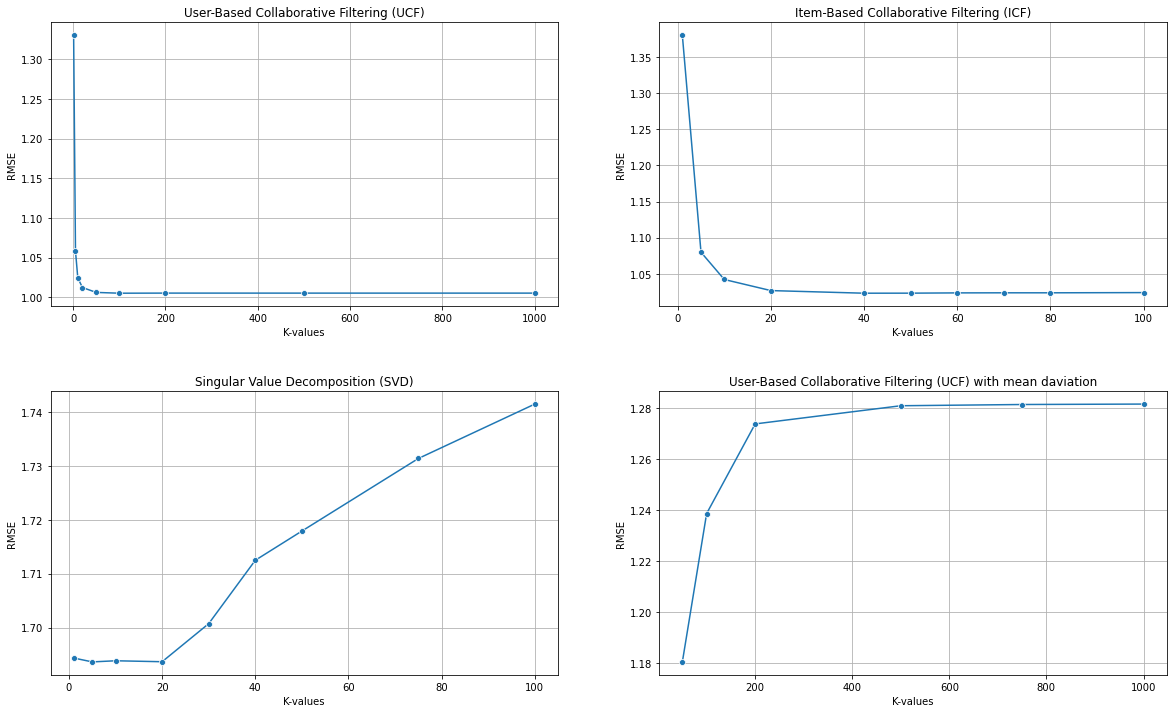

In [49]:
#Lineplots for all techniques with various K values
fig = plt.figure(figsize = (20, 12))
fig.subplots_adjust(hspace=0.3, wspace = 0.2)

ax = fig.add_subplot(2, 2, 1)
ax_ucf = sns.lineplot(x = k_ucf, y = ucf_rmse_list, marker = 'o', ax = ax)
ax_ucf.set(xlabel="K-values", ylabel = "RMSE")
ax_ucf.set_title('User-Based Collaborative Filtering (UCF)')
plt.grid()

ax = fig.add_subplot(2, 2, 2)
ax_icf = sns.lineplot(x = k_icf, y = icf_rmse_list, marker = 'o', ax = ax)
ax_icf.set(xlabel="K-values", ylabel = "RMSE")
ax_icf.set_title('Item-Based Collaborative Filtering (ICF)')
plt.grid()

ax = fig.add_subplot(2, 2, 3)
ax_svd = sns.lineplot(x = k_svd, y = svd_rmse_list, marker = 'o', ax = ax)
ax_svd.set(xlabel="K-values", ylabel = "RMSE")
ax_svd.set_title('Singular Value Decomposition (SVD)')
plt.grid()

ax = fig.add_subplot(2, 2, 4)
ax_ucf_mean = sns.lineplot(x = k_ucf_mean, y = ucf_mean_rmse_list, marker = 'o', ax = ax)
ax_ucf_mean.set(xlabel="K-values", ylabel = "RMSE")
ax_ucf_mean.set_title('User-Based Collaborative Filtering (UCF) with mean daviation')
plt.grid()

plt.show()

We can observe that naturally as we increase K the RMSE drops dramaticaly for UCF and ICF. That is not the case for SVD that at first decreases slightly and then increases linearly, as well as UCF-mean that increases logarithmicly.

More specifically:

1) **UCF**
* For UCF we can see that for K=1 the RMSE is really high compared to other K-values. This is caused because we take into account only the most similar user for every prediction we make which can give really biased decisions.

* Moreover, we can observe that after a certain K-value(at around 50 or 100) RMSE is very slightly getting better(if at all) which means big K-values are not really needed.

2) **ICF**
* For ICF we can see that it behaves almost similarly to UCF. 

(Note: you have to take into account that for ICF we used smaller K-values than UCF so the graph may be a little misleading)

3) **SVD**
* SVD has the most strange behavior of them all as at first decreases slightly having its best performance at around K=20 and from then on it icreases linearly.

4) **UCF-mean**
* UCF-with mean daviation had also a strange behavior as it increases(logarithmicly) with bigger K-values contrary to what every one would expect.

* We should also mention that we couldn't use too small K-values for this particular method because in cosine similarity matrix we had values so small that any division with them was considered division by zero giving as back Warnings and null values.

In [50]:
#User Average (UA) baseline RMSE
def ua_rmse():
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, user in enumerate(samples_array[0]):
        predicted_rating = np.sum(R[user]) / sp_sparse.csr_matrix.count_nonzero(R[user])
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [51]:
#Business Average (BA) baseline RMSE
def ba_rmse():
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, business in enumerate(samples_array[1]):
        predicted_rating = np.sum(R[:, business]) / sp_sparse.csr_matrix.count_nonzero(R[:, business])
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [52]:
#call UA & BA
ua_rmse = ua_rmse()
ba_rmse = ba_rmse()

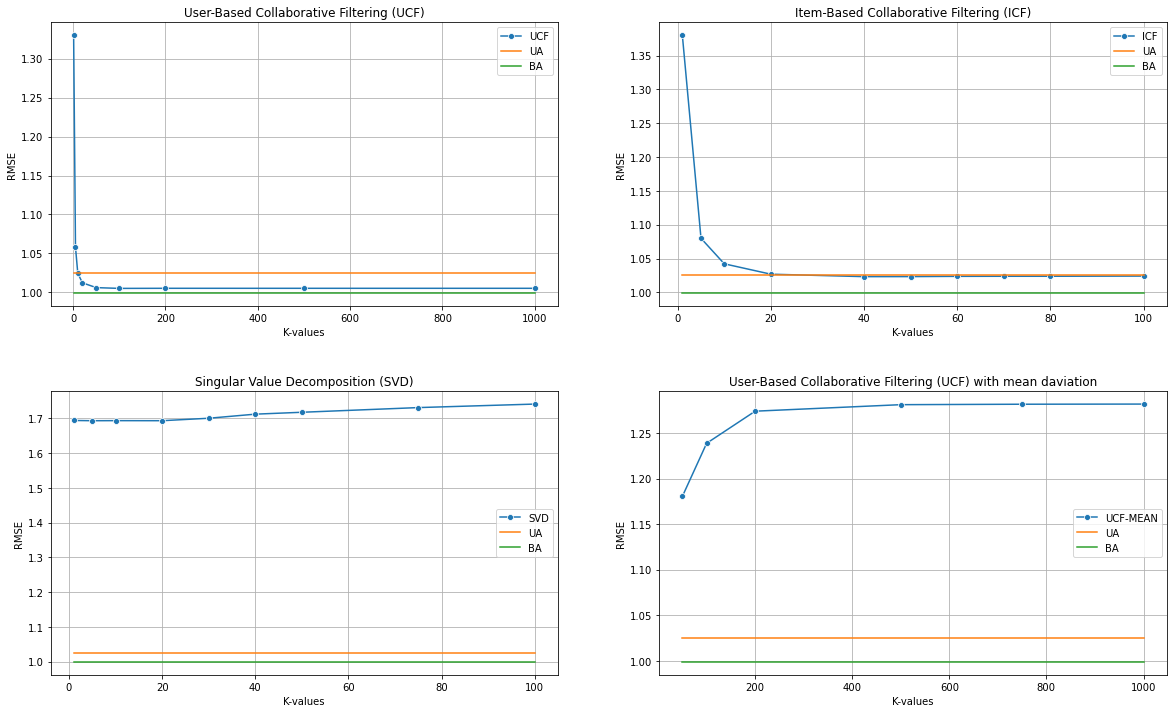

In [53]:
#Lineplots for all techniques with various K values compared with the above baselines (UA and BA)
fig = plt.figure(figsize = (20, 12))
fig.subplots_adjust(hspace=0.3, wspace = 0.2)

ax = fig.add_subplot(2, 2, 1)
ax_ucf = sns.lineplot(x = k_ucf, y = ucf_rmse_list, marker = 'o', ax = ax, legend = 'auto')
ax_ucf = sns.lineplot(x = k_ucf, y = ua_rmse, ax = ax)
ax_ucf = sns.lineplot(x = k_ucf, y = ba_rmse, ax = ax)
ax_ucf.set(xlabel="K-values", ylabel = "RMSE")
ax_ucf.set_title('User-Based Collaborative Filtering (UCF)')
ax_ucf.legend(['UCF', 'UA', 'BA'])
plt.grid()

ax = fig.add_subplot(2, 2, 2)
ax_icf = sns.lineplot(x = k_icf, y = icf_rmse_list, marker = 'o', ax = ax, legend = 'auto')
ax_icf = sns.lineplot(x = k_icf, y = ua_rmse, ax = ax)
ax_icf = sns.lineplot(x = k_icf, y = ba_rmse, ax = ax)
ax_icf.set(xlabel="K-values", ylabel = "RMSE")
ax_icf.set_title('Item-Based Collaborative Filtering (ICF)')
ax_icf.legend(['ICF', 'UA', 'BA'])
plt.grid()

ax = fig.add_subplot(2, 2, 3)
ax_svd = sns.lineplot(x = k_svd, y = svd_rmse_list, marker = 'o', ax = ax, legend = 'auto')
ax_svd = sns.lineplot(x = k_svd, y = ua_rmse, ax = ax)
ax_svd = sns.lineplot(x = k_svd, y = ba_rmse, ax = ax)
ax_svd.set(xlabel="K-values", ylabel = "RMSE")
ax_svd.set_title('Singular Value Decomposition (SVD)')
ax_svd.legend(['SVD', 'UA', 'BA'])
plt.grid()

ax = fig.add_subplot(2, 2, 4)
ax_ucf_mean = sns.lineplot(x = k_ucf_mean, y = ucf_mean_rmse_list, marker = 'o', ax = ax)
ax_ucf_mean = sns.lineplot(x = k_ucf_mean, y = ua_rmse, ax = ax)
ax_ucf_mean = sns.lineplot(x = k_ucf_mean, y = ba_rmse, ax = ax)
ax_ucf_mean.set(xlabel="K-values", ylabel = "RMSE")
ax_ucf_mean.set_title('User-Based Collaborative Filtering (UCF) with mean daviation')
ax_ucf_mean.legend(['UCF-MEAN', 'UA', 'BA'])
plt.grid()

plt.show()

We can observe that simple baselines such as User Average(UA) and Business Average(BA) perform almost similar if not better in some cases as UCF & ICF and way better than SVD & UCF-mean.

In [54]:
#Modify the following lists so they are the same length for dataframe format
max_lenList = max(len(k_ucf), len(k_icf), len(k_svd), len(k_ucf_mean))

for i in range(0, max_lenList-len(k_ucf)):
    k_ucf.append(0)
    ucf_rmse_list.append(None)

for i in range(0, max_lenList-len(k_icf)):
    k_icf.append(0)
    icf_rmse_list.append(None)
    
for i in range(0, max_lenList-len(k_svd)):
    k_svd.append(0)
    svd_rmse_list.append(None)
    
for i in range(0, max_lenList-len(k_ucf_mean)):
    k_ucf_mean.append(0)
    ucf_mean_rmse_list.append(None)
    

In [55]:
#Print the results of all methods above as dataframes
import pandas as pd

data = {'K-UCF':  k_ucf,
        'UCF RMSE': ucf_rmse_list,
        'K-ICF': k_icf,
        'ICF RMSE': icf_rmse_list,
        'K-SVD': k_svd,
        'SVD RMSE': svd_rmse_list,
        'K-UCF-MEAN': k_ucf_mean,
        'UCF MEAN RMSE': ucf_mean_rmse_list }

df_results = pd.DataFrame (data, columns = ['K-UCF', 'UCF RMSE', 'K-ICF', 'ICF RMSE', 'K-SVD', 'SVD RMSE', 'K-UCF-MEAN', 'UCF MEAN RMSE'])

df_results

,K-UCF,UCF RMSE,K-ICF,ICF RMSE,K-SVD,SVD RMSE,K-UCF-MEAN,UCF MEAN RMSE
0,1,1.330019,1,1.379748,1,1.694331,50,1.180410
1,5,1.058155,5,1.080011,5,1.693604,100,1.238711
2,10,1.024520,10,1.042318,10,1.693815,200,1.273932
3,20,1.012231,20,1.026987,20,1.693638,500,1.281077
4,50,1.006068,40,1.023363,30,1.700716,750,1.281562
5,100,1.005074,50,1.023427,40,1.712497,1000,1.281731
6,200,1.005204,60,1.023798,50,1.717927,0,NaN
7,500,1.005182,70,1.023917,75,1.731417,0,NaN
8,1000,1.005185,80,1.023918,100,1.741534,0,NaN
9,0,NaN,100,1.024207,0,NaN,0,NaN


K-values where each method performed the best(smallest RMSE):

| K-ucf  | K-icf | K-svd| K-ucf-mean|
| ------ | ----- | ---- | --------- |
|  100   |  40   |   5  |    50     |



In [56]:
print("RMSE for User Average (UA) baseline: ", ua_rmse)
print("RMSE for Business Average (BA) baseline: ", ba_rmse)

RMSE for User Average (UA) baseline:  1.0254368051556848
RMSE for Business Average (BA) baseline:  0.9988980538467498


Overall the smallest RMSE and subsequently the best performance is achieved by **Business Average baseline**.